**Import Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import zipfile
import os



**Preparing the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Capstone_Dataset/FaceCare-dataset-1.zip' -d './dataset1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Capstone_Dataset/FaceCare-dataset-1.zip
   creating: ./dataset1/train/
   creating: ./dataset1/train/Acne/
  inflating: ./dataset1/train/Acne/00a6e318-fe21-4e01-b02f-f7d55d7c0096_jpg.rf.58c525dca44cb6c510c39f4df4be764b.jpg  
  inflating: ./dataset1/train/Acne/00a6e318-fe21-4e01-b02f-f7d55d7c0096_jpg.rf.c0827371c26c020129ae54e75d55d4fb.jpg  
  inflating: ./dataset1/train/Acne/01199a6b-f8b7-468b-8a3e-de41b2b6cc39_jpg.rf.4c56523be4ebd87d14bf23ea53bd1809.jpg  
  inflating: ./dataset1/train/Acne/01199a6b-f8b7-468b-8a3e-de41b2b6cc39_jpg.rf.967b0b78801ef112269a99eb40148a37.jpg  
  inflating: ./dataset1/train/Acne/01199a6b-f8b7-468b-8a3e-de41b2b6cc39_jpg.rf.e108f7656154019e9e0ca3a0baf7846f.jpg  
  inflating: ./dataset1/train/Acne/01e0130f-2574-4895-97e6-772dd76d5a1c_jpg.rf.1c2cd94480d84598d5dc3457e2e89af8.jpg  
  inflating: ./dataset1

In [ ]:
train_dir = './dataset1/train'
test_dir = './dataset1/valid'
img_height, img_width = 416, 416

**Preprocessing Data and Data Augmentation**

In [ ]:
import numpy as np
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.2, 1),
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalization
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and iterate training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
)

# Load and iterate validation dataset
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
)
steps_per_epoch_train = np.ceil(train_generator.samples / 32).astype(int)
print(steps_per_epoch_train)
steps_per_epoch_val = np.ceil(validation_generator.samples  / 32).astype(int)
print(steps_per_epoch_val)

Found 1425 images belonging to 2 classes.
Found 357 images belonging to 2 classes.
45
12


In [ ]:
from sklearn.utils import class_weight

train_labels = train_generator.classes

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Convert the class weights to a dictionary
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print the class weights
print("Class weights:", class_weights_dict)

Class weights: {0: 0.5414133738601824, 1: 6.536697247706422}


In [ ]:
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 414, 414, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 207, 207, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 205, 205, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 102, 102, 64)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 102, 102, 64)      0         
                                                                 
 flatten (Flatten)           (None, 665856)            0

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch_train,
    epochs = 30,
    validation_data= validation_generator,
    validation_steps = steps_per_epoch_val,
    class_weight=class_weights_dict,
)

Epoch 1/30
45/45 [==============================] - 607s 13s/step - loss: 1.8033 - accuracy: 0.8189 - val_loss: 1.7146 - val_accuracy: 0.6807
Epoch 2/30
45/45 [==============================] - 603s 13s/step - loss: 0.6151 - accuracy: 0.9474 - val_loss: 0.6301 - val_accuracy: 0.9216
Epoch 3/30
45/45 [==============================] - 595s 13s/step - loss: 0.4842 - accuracy: 0.9474 - val_loss: 0.3176 - val_accuracy: 0.9944
Epoch 4/30
45/45 [==============================] - 602s 13s/step - loss: 0.3729 - accuracy: 0.9488 - val_loss: 0.2305 - val_accuracy: 1.0000
Epoch 5/30
45/45 [==============================] - 598s 13s/step - loss: 0.2366 - accuracy: 0.9698 - val_loss: 0.2306 - val_accuracy: 0.9692
Epoch 6/30
45/45 [==============================] - 602s 13s/step - loss: 0.2246 - accuracy: 0.9418 - val_loss: 0.3480 - val_accuracy: 0.9216
Epoch 7/30
45/45 [==============================] - 601s 13s/step - loss: 0.2724 - accuracy: 0.9698 - val_loss: 0.1349 - val_accuracy: 1.0000
Epoch 

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

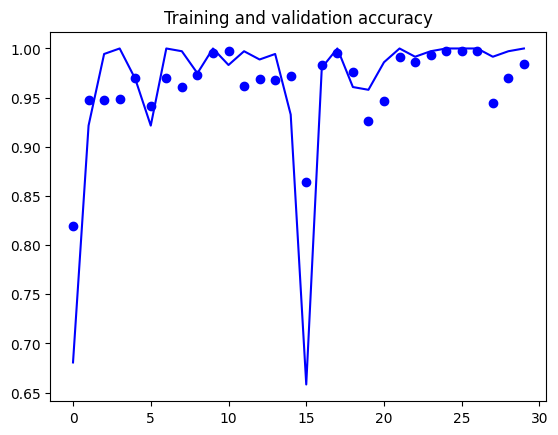

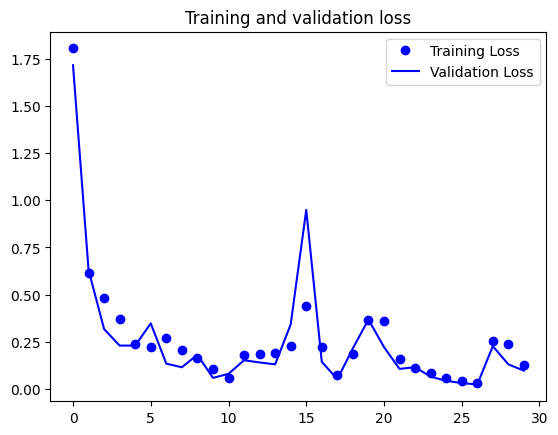

In [ ]:
plot_loss_acc(history)

In [ ]:
import random
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def load_and_preprocess_image(directory):
    # Get a list of all the images in the directory
    all_images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                all_images.append(os.path.join(root, file))

    # Select a random image
    random_image_path = random.choice(all_images)

    # Load the image
    img = image.load_img(random_image_path, target_size=(img_height, img_width))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the shape expected by the model
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array_expanded = preprocess_input(img_array_expanded)

    return img, img_array_expanded, random_image_path




1/1 [==============================] - 1s 797ms/step


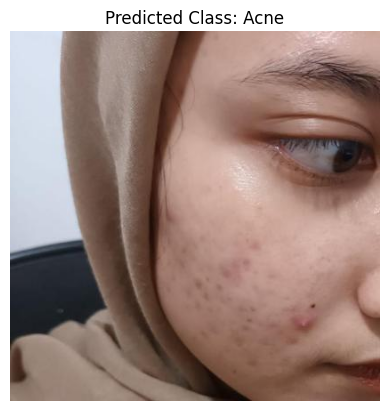

Random Image Path: ./dataset1/valid/Acne/125abad4-0ee7-4d10-9e3d-b19b41c0aee2_jpg.rf.656a54979af419c06a02a3201f9c4efc.jpg
Predicted Probabilities:
Class 0: 1.0000
Class 1: 0.0000


In [ ]:
original_img, img_array, random_image_path = load_and_preprocess_image(test_dir)

predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)[0]

class_labels = list(train_generator.class_indices.keys())
# Display the image
plt.imshow(original_img)
plt.title(f"Predicted Class: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()

# Print the results
print(f"Random Image Path: {random_image_path}")
print("Predicted Probabilities:")
for i, prob in enumerate(predictions[0]):
    print(f"Class {i}: {prob:.4f}")

In [ ]:
model.save("./drive/MyDrive/Colab Notebooks/face_care_efficientnet_CNN.keras")